In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import seaborn as sns
sns.set()
import pandas as pd
import gc
gc.collect()
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from tqdm import tqdm

from pyhive import presto
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
requests.packages.urllib3.disable_warnings()
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gc
gc.collect()
gc.collect()

tqdm.pandas()

/home/ronak/anaconda3/envs/customer_v1/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### CRI

In [2]:
tqdm.pandas()
def download_data(city,date,data_file):
    conn = presto.connect(
        host='10.160.0.62',
        port=8060,
        protocol='http',
        catalog='hive',
        schema='mongodb',
        username='ronak',
        # requests_kwargs=req_kw,
    )
    order_date_query_test = """Select updatedAt,customer,status,orderdate,serviceobj_city,spdfraud_flag
    from hive.mongodb.orders 
    where (orderdate =  '{date}') and (status ='customerCancelled') and (serviceobj_city='{city}')
    """.format(city=city,date=date)
    df_order_date_test = pd.read_sql(order_date_query_test, conn)
    df_order_date_test.to_csv(data_file)

#### Cancelled Rider Issues: (new →  (riderBusy,riderRejected)*  → (customerCancelled))

def get_status_from_slice(each_slice):
    status_index= [i for i, s in enumerate(each_slice.split(',')) if 'status' in s][0]
    first_status=each_slice.split(',')[status_index]
    request_time=float(extract_epoch_timestamp(each_slice.split(',')[status_index+1]))
    return preprocess_status(first_status),request_time
def get_all_new_index(split_list):
    new_string="'status': 'new'"
    all_new_index=[i for i, s in enumerate(split_list) if new_string in s]
    return all_new_index
def get_all_otw_index(split_list):
    new_string="'status': 'onTheWay'"
    all_otw_index=[i for i, s in enumerate(split_list) if new_string in s]
    return all_otw_index

def get_all_riderRejected_index(split_list):
    rider_rejected_string="'status': 'riderRejected'"
    all_rr_index=[i for i, s in enumerate(split_list) if rider_rejected_string in s]
    return all_rr_index

def get_all_cancelled_index(split_list):
    cancelled_String="'status': 'customerCancelled'"
    cancelled_Index=[i for i, s in enumerate(split_list) if cancelled_String in s]
    return cancelled_Index

import re
def extract_epoch_timestamp(a):
    m = re.search('[0-9]{3,}.[0-9]{1}', a)
    if m:
        found = m.group(0)
        return found
def preprocess_status(x):
    return x.replace('\'',"").replace(' ',"").replace('status:',"")   

def get_status_from_slice(each_slice):
    status_index= [i for i, s in enumerate(each_slice.split(',')) if 'status' in s][0]
    first_status=each_slice.split(',')[status_index]
    request_time=float(extract_epoch_timestamp(each_slice.split(',')[status_index+1]))
    return preprocess_status(first_status),request_time

def get_start_stop_indices(split_list):
    new_indices=get_all_new_index(split_list)
    cancelled_indices=get_all_cancelled_index(split_list)
    new_cancelled_indices=list(zip(new_indices,cancelled_indices))
    return new_cancelled_indices
def get_non_none_status_for_range(start,stop,split_list):
    return list(filter(None.__ne__, [get_all_status_for_range(split_list[curr_index]) for curr_index in range(start,stop+1)]))
def get_all_status_for_range(each_slice):
     if 'status' in each_slice:
        status_index= [i for i, s in enumerate(each_slice.split(',')) if 'status' in s][0]
        first_status=each_slice.split(',')[status_index]
        request_time=float(extract_epoch_timestamp(each_slice.split(',')[status_index+1]))
        return preprocess_status(first_status),request_time

def get_if_expected_list(split_list,start_stop):
    status_list=get_non_none_status_for_range(*start_stop,split_list)
    allowed_status=[
        'new',
        'riderBusy',
        'riderRejected',
        'notReachedToRider',
        'customerCancelled'
    ]
    filtered_list=[x for x in status_list if x[0] in allowed_status]
    return (len(filtered_list)==len(status_list))

def get_count_in_cell(cell):
    split_list= cell.split('{')
    return sum([get_if_expected_list(split_list,start_stop) for start_stop in get_start_stop_indices(split_list)])

def drop_unnamed(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')]

def get_cri(data_file):
    orders=pd.read_csv(data_file)
    orders=drop_unnamed(orders)
    orders.head(2)
    updated_at_split=orders['updatedAt'].progress_apply(lambda x: x.strip('[]'))
    count=updated_at_split.progress_apply(get_count_in_cell).sum()
    return count

def execute(city,date):
    data_file='CRI_{city}_{date}.csv'.format(city=city,date=date)
    download_data(city,date,data_file)
    count=get_cri(data_file)
    from pathlib import Path
    Path(data_file+'_'+str(count)).touch()
    print('# CancelledRiderIssues- (new →  (riderBusy,riderRejected,notReachedToRider)*  → (customerCancelled)) = {0} for {1}'.format(count,data_file))
    return city, date, count

### CCRA

In [3]:
def get_count_ccra(cell):
    split_list= cell.split('{')
    return sum([check_if_ccara(split_list,start_stop) for start_stop in get_start_stop_indices(split_list)])

def check_if_ccara(split_list,start_stop):
    
    status_list=get_non_none_status_for_range(*start_stop,split_list)
    allowed_list=[
        'new',
        'onTheWay',
        'customerCancelled'
    ]
    def status_preset_check(status):
        return any([status in y for y in status_list])

    return all([status_preset_check(allowed_list[i]) and status_preset_check(allowed_list[i + 1]) for i in range(len(allowed_list) - 1)])
def get_ccra(data_file):
    orders=pd.read_csv(data_file)
    orders=drop_unnamed(orders)
    orders.head(2)
    updated_at_split=orders['updatedAt'].progress_apply(lambda x: x.strip('[]'))
    count=updated_at_split.progress_apply(get_count_ccra).sum()
    return count
def execute_ccra(city,date):
    data_file='CCARA_{city}_{date}.csv'.format(city=city,date=date)
    download_data(city,date,data_file)
    count=get_ccra(data_file)
    from pathlib import Path
    Path(data_file+'_'+str(count)).touch()
    print('# CancelledAfterRiderAccepted- (new → (*)* → onTheWay → (*)* → customerCancelled) = {0} for {1}'.format(count,data_file))
    return city, date, count

### Expriy

In [9]:
def download_data_exp(city,start_date,end_date,data_file):
    conn = presto.connect(
        host='10.160.0.62',
        port=8060,
        protocol='http',
        catalog='hive',
        schema='mongodb',
        username='ronak',
        # requests_kwargs=req_kw,
    )
    order_date_query_test = """Select orderdate as date,serviceobj_city as city,count(*) as exp_count
from hive.mongodb.orders 
where (status ='expired') and  (serviceobj_city='{city}') and orderdate BETWEEN '{start_date}' and '{end_date}' 
group by (orderdate),serviceobj_city order by orderdate
    """.format(city=city,start_date=start_date,end_date=end_date)
    df_order_date_test = pd.read_sql(order_date_query_test, conn)
    df_order_date_test.to_csv(data_file)
    return df_order_date_test

def execute_expiries(city,start_date,end_date):
    data_file='exp_{city}_{start_date}_{end_date}.csv'.format(city=city,start_date=start_date,end_date=end_date)
    return download_data_exp(city,start_date,end_date,data_file)



### Execute

In [ ]:
date1 = '2020-01-27'
date2 = '2020-02-07'
date_list = pd.date_range(date1, date2).date.astype(str).tolist()
city_list=['Kolkata','Delhi']
cri=[execute(city,date) for city in city_list for date in date_list]
cri=pd.DataFrame(cri,columns=['city','date','cri_count'])
ccra=[execute_ccra(city,date) for city in city_list for date in date_list]
ccra_df=pd.DataFrame(ccra,columns=['city','date','ccra_count'])
city_wise_numbers=pd.merge(ccra_df,cri,on=['city','date'],how='inner')
exp_data=[execute_expiries(city,date1,date2) for city in city_list]
exp_data_df=pd.concat(exp_data)
metrics=pd.merge(exp_data_df,city_wise_numbers,on=['city','date'],how='inner')

In [13]:
metrics

,date,city,exp_count,ccra_count,cri_count
0,2020-01-27,Kolkata,9010,10864,9544
1,2020-01-28,Kolkata,8013,10926,13172
2,2020-01-29,Kolkata,12573,10133,9493
3,2020-01-30,Kolkata,7610,10021,8364
4,2020-01-31,Kolkata,8297,10347,8808
5,2020-02-01,Kolkata,3965,13169,5709
6,2020-02-02,Kolkata,6480,9838,5088
7,2020-02-03,Kolkata,8017,15280,6542
8,2020-02-04,Kolkata,6094,15067,5967
9,2020-02-05,Kolkata,5752,14865,5650


### Get number of expries CI- Calculation

#### Kolkata

In [7]:
city='Kolkata'
start_date='2019-11-15'
end_date='2020-02-11'
data_file='exp_{city}_{start_date}_{end_date}.csv'.format(city=city,start_date=start_date,end_date=end_date)

,exp_count
orderdate,
2019-11-15,2732
2019-11-16,1431
2019-11-17,2191
2019-11-18,1682
2019-11-19,3364


,exp_count,weekday
orderdate,,
2020-01-13,9199,Monday
2020-01-20,9783,Monday
2020-01-27,9010,Monday
2020-02-03,8017,Monday


,exp_count,weekday
orderdate,,
2020-01-14,6122,Tuesday
2020-01-21,8534,Tuesday
2020-01-28,8013,Tuesday
2020-02-04,6094,Tuesday


,exp_count,weekday
orderdate,,
2020-01-15,5675,Wednesday
2020-01-22,8643,Wednesday
2020-01-29,12573,Wednesday
2020-02-05,5752,Wednesday


,exp_count,weekday
orderdate,,
2020-01-16,5324,Thursday
2020-01-23,4375,Thursday
2020-01-30,7610,Thursday
2020-02-06,4824,Thursday


(9002.25, 7833.284306150097, 10171.215693849903)

(7190.75, 5172.6543531260395, 9208.84564687396)

(8160.75, 2989.7607322182157, 13331.739267781784)

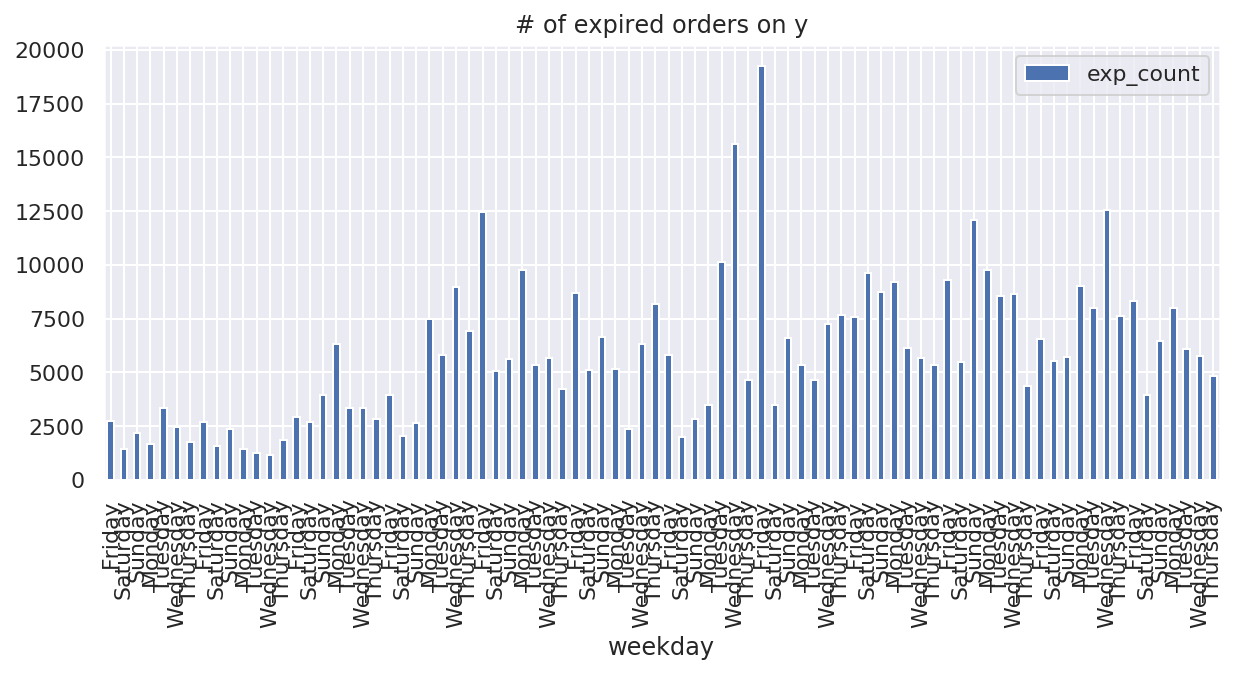

In [144]:
def download_data(city,date,data_file):
    conn = presto.connect(
        host='10.160.0.62',
        port=8060,
        protocol='http',
        catalog='hive',
        schema='mongodb',
        username='ronak',
        # requests_kwargs=req_kw,
    )
    order_date_query_test = """Select orderdate,serviceobj_city as city,count(*) as exp_count
from hive.mongodb.orders 
where (status ='expired') and  (serviceobj_city='{city}') and orderdate BETWEEN '{start_date}' and '{end_date}' 
group by (orderdate),serviceobj_city order by orderdate
    """.format(city=city,start_date=start_date,end_date=end_date)
    df_order_date_test = pd.read_sql(order_date_query_test, conn)
    df_order_date_test.to_csv(data_file)

download_data(city,date,data_file)

exp_data_ts=pd.read_csv(data_file,parse_dates=['orderdate'],index_col=['orderdate'])
exp_data_ts=drop_unnamed(exp_data_ts)

exp_data_ts.head()
exp_data_ts.loc[:,'weekday']=exp_data_ts.index.day_name()
exp_data_ts.plot(x='weekday',y='exp_count',kind='bar',figsize=(10,4),title='# of expired orders on y')

import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

exp_data_ts[(exp_data_ts['weekday']=='Monday')].tail(n)
exp_data_ts[(exp_data_ts['weekday']=='Tuesday')].tail(4)
exp_data_ts[(exp_data_ts['weekday']=='Wednesday')].tail(4)
exp_data_ts[(exp_data_ts['weekday']=='Thursday')].tail(4)
n=4
mon=exp_data_ts[(exp_data_ts['weekday']=='Monday')].tail(n)['exp_count']
tue=exp_data_ts[(exp_data_ts['weekday']=='Tuesday')].tail(n)['exp_count']
wed=exp_data_ts[(exp_data_ts['weekday']=='Wednesday')].tail(n)['exp_count']
mean_confidence_interval(mon)
mean_confidence_interval(tue)
mean_confidence_interval(wed)

#### Delhi

In [145]:
city='Delhi'
start_date='2019-11-15'
end_date='2020-02-11'
data_file='exp_{city}_{start_date}_{end_date}.csv'.format(city=city,start_date=start_date,end_date=end_date)

,exp_count
orderdate,
2019-11-15,60
2019-11-16,29
2019-11-17,39
2019-11-18,58
2019-11-19,72


,exp_count,weekday
orderdate,,
2020-01-13,352,Monday
2020-01-20,310,Monday
2020-01-27,3064,Monday
2020-02-03,2394,Monday


,exp_count,weekday
orderdate,,
2020-01-14,287,Tuesday
2020-01-21,317,Tuesday
2020-01-28,6453,Tuesday
2020-02-04,2269,Tuesday


,exp_count,weekday
orderdate,,
2020-01-15,318,Wednesday
2020-01-22,333,Wednesday
2020-01-29,3425,Wednesday
2020-02-05,2449,Wednesday


,exp_count,weekday
orderdate,,
2020-01-16,312,Thursday
2020-01-23,1239,Thursday
2020-01-30,2564,Thursday
2020-02-06,2099,Thursday


(1530.0, -715.7745877131129, 3775.774587713113)

(2331.5, -2282.942797481456, 6945.942797481456)

(1631.25, -850.2985583630716, 4112.798558363072)

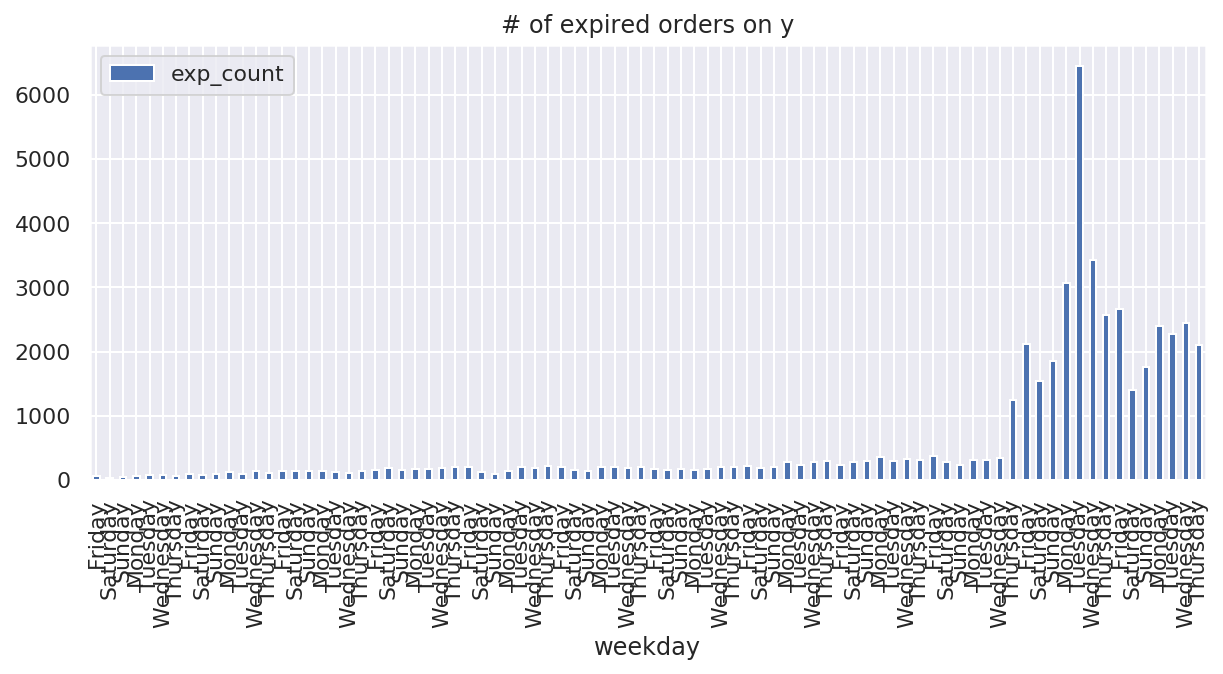

In [146]:
def download_data(city,date,data_file):
    conn = presto.connect(
        host='10.160.0.62',
        port=8060,
        protocol='http',
        catalog='hive',
        schema='mongodb',
        username='ronak',
        # requests_kwargs=req_kw,
    )
    order_date_query_test = """Select orderdate,count(*) as exp_count
from hive.mongodb.orders 
where (status ='expired') and  (serviceobj_city='{city}') and orderdate BETWEEN '{start_date}' and '{end_date}' 
group by (orderdate) order by orderdate
    """.format(city=city,start_date=start_date,end_date=end_date)
    df_order_date_test = pd.read_sql(order_date_query_test, conn)
    df_order_date_test.to_csv(data_file)

download_data(city,date,data_file)

exp_data_ts=pd.read_csv(data_file,parse_dates=['orderdate'],index_col=['orderdate'])
exp_data_ts=drop_unnamed(exp_data_ts)

exp_data_ts.head()
exp_data_ts.loc[:,'weekday']=exp_data_ts.index.day_name()
exp_data_ts.plot(x='weekday',y='exp_count',kind='bar',figsize=(10,4),title='# of expired orders on y')

import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

exp_data_ts[(exp_data_ts['weekday']=='Monday')].tail(n)
exp_data_ts[(exp_data_ts['weekday']=='Tuesday')].tail(4)
exp_data_ts[(exp_data_ts['weekday']=='Wednesday')].tail(4)
exp_data_ts[(exp_data_ts['weekday']=='Thursday')].tail(4)
n=4
mon=exp_data_ts[(exp_data_ts['weekday']=='Monday')].tail(n)['exp_count']
tue=exp_data_ts[(exp_data_ts['weekday']=='Tuesday')].tail(n)['exp_count']
wed=exp_data_ts[(exp_data_ts['weekday']=='Wednesday')].tail(n)['exp_count']
mean_confidence_interval(mon)
mean_confidence_interval(tue)
mean_confidence_interval(wed)

In [159]:
mean_confidence_interval(exp_data_ts[(exp_data_ts['exp_count']<6000)& (exp_data_ts['exp_count']>2000)].tail(13)['exp_count'])

(2559.5555555555557, 2221.325869098252, 2897.7852420128593)